## CIFAR 10

In [14]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [15]:
from fastai.conv_learner import *
from fastai.models.cifar10.wideresnet import wrn_22_cat, wrn_22, WideResNetConcat
torch.backends.cudnn.benchmark = True
PATH = Path("data/cifar10/")
os.makedirs(PATH,exist_ok=True)

In [16]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

bs=512
sz=32
workers=7

In [19]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

def pad(img, p=4, padding_mode='reflect'):
    return Image.fromarray(np.pad(np.asarray(img), ((p, p), (p, p), (0, 0)), padding_mode))


def get_loaders(bs, num_workers):
    traindir = str(PATH/'train')
    valdir = str(PATH/'test')
    tfms = [transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]

    aug_tfms =transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
        ] + tfms)
    
    train_dataset = datasets.ImageFolder(
        traindir,
        aug_tfms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)

    val_dataset = datasets.ImageFolder(valdir, transforms.Compose(tfms))

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    aug_dataset = datasets.ImageFolder(valdir, aug_tfms)

    aug_loader = torch.utils.data.DataLoader(
        aug_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, aug_loader

def torch_loader(data_path, size):
    if not os.path.exists(data_path+'/train'): download_cifar10(data_path)

    # Data loading code
    traindir = os.path.join(data_path, 'train')
    valdir = os.path.join(data_path, 'test')
    normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
    tfms = [transforms.ToTensor(), normalize]

    train_tfms = transforms.Compose([
        pad, # TODO: use `padding` rather than assuming 4
        transforms.RandomCrop(size),
        transforms.RandomHorizontalFlip(),
    ] + tfms)
    val_tfms = transforms.Compose(tfms)

    train_dataset = datasets.ImageFolder(traindir, train_tfms)
    val_dataset = datasets.ImageFolder(valdir, val_tfms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs*2, shuffle=False,
        num_workers=workers, pin_memory=True)
    
    aug_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, train_tfms),
        batch_size=bs*2, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    aug_loader = DataPrefetcher(aug_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    data.sz = size
    data.aug_dl = aug_loader
    return data

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [20]:
data = torch_loader(str(PATH), sz)

In [6]:
'''Pre-activation ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Identity Mappings in Deep Residual Networks. arXiv:1603.05027
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)
    

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, concatpool=False):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.pool = AdaptiveConcatPool2d() if concatpool else nn.AdaptiveMaxPool2d((1,1))
        
        self.linear = nn.Linear(512*block.expansion*(concatpool+1), num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
#         out = F.adaptive_max_pool2d(out, 1)
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out))

def preact_resnet18(): return PreActResNet(PreActBlock, [2,2,2,2])
def preact_resnet2332(): return PreActResNet(PreActBlock, [2,3,3,2])
def preact_resnet3333(): return PreActResNet(PreActBlock, [3,3,3,3])
def preact_resnet34(): return PreActResNet(PreActBlock, [3,4,6,3])
def preact_resnet50(): return PreActResNet(PreActBottleneck, [3,4,6,3])
def preActResNet101(): return PreActResNet(PreActBottleneck, [3,4,23,3])
def preActResNet152(): return PreActResNet(PreActBottleneck, [3,8,36,3])


In [7]:
# m = WideResNetConcat(num_groups=3, N=3, num_classes=10, k=1, drop_p=0.)

In [8]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=2e-4
lr=1.2
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .08), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=13, lr=(.08,.7), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=13, lr=(.7,.04), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=4, lr=(.04,.01), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.530031   1.943406   0.4227    
    1      1.2012     1.305962   0.5867                   
    2      0.943712   1.168575   0.6183                    
    3      0.756506   0.692619   0.7633                    
    4      0.654206   0.767852   0.7499                    
    5      0.562807   0.634065   0.7862                    
    6      0.516113   0.682573   0.7724                    
    7      0.482468   0.637977   0.7995                    
    8      0.449063   0.620458   0.8015                    
    9      0.42889    0.495395   0.8323                    
    10     0.430707   0.548799   0.8162                    
    11     0.409158   0.845457   0.7459                    
    12     0.391512   0.911755   0.7214                    
    13     0.378444   0.689216   0.7823                    
    14     0.375877   0.744191   0.759                     
    15     0.365031   0.568236   0.8211                   

[array([0.22934]), 0.9348000016212463]

In [11]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=2e-4
lr=1.2
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .08), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=13, lr=(.08,.7), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=13, lr=(.7,.04), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=4, lr=(.04,.01), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.533039   2.389389   0.379     
    1      1.223727   1.602819   0.493                    
    2      0.962103   1.112428   0.6499                    
    3      0.801654   0.818247   0.7187                    
    4      0.665065   0.750118   0.747                     
    5      0.579346   0.658142   0.7751                    
    6      0.530339   0.75548    0.7594                    
    7      0.490638   0.641217   0.7873                    
    8      0.455531   0.595093   0.8031                    
    9      0.451248   0.516161   0.8262                    
    10     0.413226   0.54458    0.8183                    
    11     0.400499   0.560852   0.8121                    
    12     0.395301   0.568609   0.8093                    
    13     0.375691   0.570963   0.8069                    
    14     0.387244   0.818813   0.7639                    
    15     0.358484   0.551007   0.818                    

[array([0.23477]), 0.9360000011444092]

In [21]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=2e-4
lr=1.2
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .07), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=13, lr=(.07,.6), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=13, lr=(.6,.04), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=4, lr=(.04,.01), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.52945    2.039119   0.3995    
    1      1.150145   1.432012   0.5503                   
    2      0.933906   0.807225   0.7225                    
    3      0.774642   0.948592   0.6896                    
    4      0.636559   0.775617   0.7264                    
    5      0.566586   0.824548   0.7235                    
    6      0.503258   0.583165   0.8135                    
    7      0.478717   0.691443   0.7669                    
    8      0.447086   0.555022   0.8165                    
    9      0.418356   0.618205   0.7901                    
    10     0.395662   0.595514   0.8031                    
    11     0.39469    0.706471   0.7796                    
    12     0.379789   0.690055   0.7797                    
    13     0.359075   0.565026   0.8166                    
    14     0.348746   0.467955   0.8505                    
    15     0.326468   0.515632   0.833                    

[array([0.23339]), 0.933199999332428]

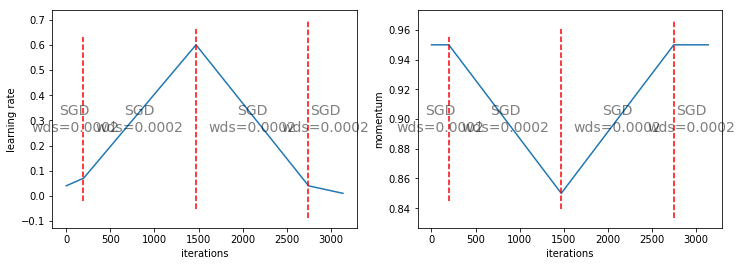

In [31]:
learn.sched.plot_lr()

In [22]:
def get_TTA_accuracy(learn):
    preds, targs = learn.TTA()
    # combining the predictions across augmented and non augmented inputs
    preds = 0.6 * preds[0] + 0.4 * preds[1:].sum(0)
    return accuracy_np(preds, targs)

def get_TTA_accuracy_2(learn):
    log_preds,y = learn.TTA()
    preds = np.mean(np.exp(log_preds),0)
    acc = accuracy(torch.FloatTensor(preds),torch.LongTensor(y))
    print('TTA acc:', acc)

In [ ]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=2e-4
learn.clip = 2e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .07), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=13, lr=(.07,.5), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=13, lr=(.5,.04), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=4, lr=(.04,.01), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

In [28]:
print(get_TTA_accuracy(learn), get_TTA_accuracy_2(learn))

0.7235

### END TESTING

In [ ]:
m = pre_resnet18()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=6, lr=(.05,.9), lr_decay=DecayType.COSINE, momentum=(0.95,0.85), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=4, lr=1, momentum=0.85),
    TrainingPhase(**def_phase, epochs=7, lr=(.9,.01), lr_decay=DecayType.COSINE, momentum=(0.85,0.95), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=3, lr=(.01,.0005), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

In [ ]:
learn.sched.plot_lr()

In [ ]:
m = WideResNetConcat(num_groups=3, N=3, num_classes=10, k=1, drop_p=0.)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=1.5
learn.clip = 3e-1
%time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(12,22,0.95,0.85), loss_scale=512)